In [1]:
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db as db
from invisible_cities.cities.phyllis import pmt_deconvolver

In [2]:
def labels(xlabel, ylabel, title, fontsize):
    """Set x and y labels"""
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title ( title, fontsize=fontsize)

In [ ]:
All the waveforms can be taken from the Canfranc's machine:
/analysis/run_no/hdf5/data/run_{run_no}_0000_waveforms.h5

### PMTs

In [3]:
run_no  = 8428
wf_path = '/Users/carmenromoluque/Calibration/january2021_cal2/PMT/'
rwf     = tb.open_file(wf_path + f'run_{run_no}_0000_waveforms.h5')

bins = int(800/0.025)#mus  ## Buffer for PMTs: 800mus, sample: 0.025
time = np.array(range(0, bins, 1))

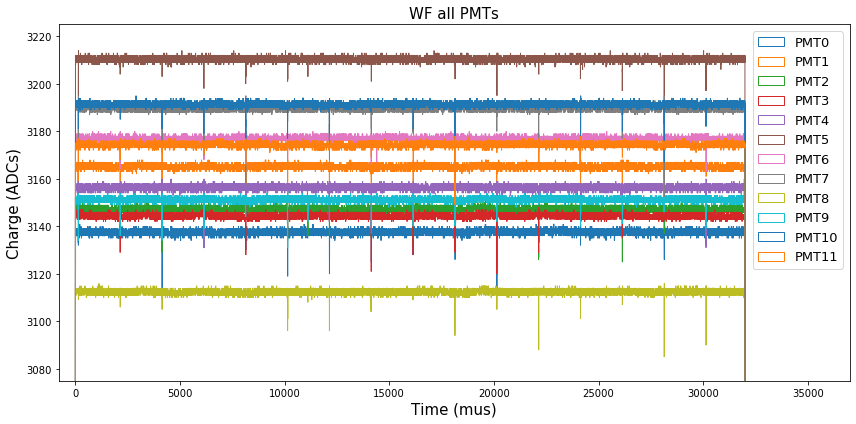

In [4]:
fig = plt.figure(figsize=(12, 6))
for pmt_n in range(12):
    charges_rwf = rwf.root.RD.pmtrwf[100][pmt_n] #event 100, randomly selected
    plt.hist(time, bins=bins, weights=charges_rwf, range=(0, bins), label=f'PMT{pmt_n}', histtype='step')
plt.xlim(-800,37000)
plt.ylim(3075,3225)

labels("Time (mus)", "Charge (ADCs)", f'WF all PMTs', 15)
lnd = plt.legend(loc=1, fontsize=13)
plt.tight_layout()

### Correct waveforms deconvolving and applying blr

In [6]:
def get_vectors(h5f):
    pmtrwf  = h5f.root.RD.pmtrwf
    pmtblr  = h5f.root.RD.pmtblr
    sipmrwf = h5f.root.RD.sipmrwf
    return pmtrwf, pmtblr, sipmrwf

def get_rwf_vectors(h5in):
    """Return the most relevant fields stored in a raw data file"""
    pmtrwf, pmtblr, sipmrwf = get_vectors(h5in)
    NEVT_pmt , _, _         = pmtrwf .shape
    NEVT_simp, _, _         = sipmrwf.shape

    assert NEVT_simp == NEVT_pmt
    return NEVT_pmt, pmtrwf, sipmrwf, pmtblr

In [7]:
db_file    = '/Users/carmenromoluque/IC/invisible_cities/database/localdb.NEWDB.sqlite3'

n_baseline = int(62400)
nevt, pmtrwf, sipmrwf, _ = get_rwf_vectors(rwf)
corr_wfs = []
for evt in pmtrwf:
    corr_wf = pmt_deconvolver(db_file, run_no, n_baseline)(evt)
    corr_wfs.append(corr_wf)
corr_wfs = np.array(corr_wfs)

In [8]:
np.array(corr_wfs).shape

(270, 12, 32000)

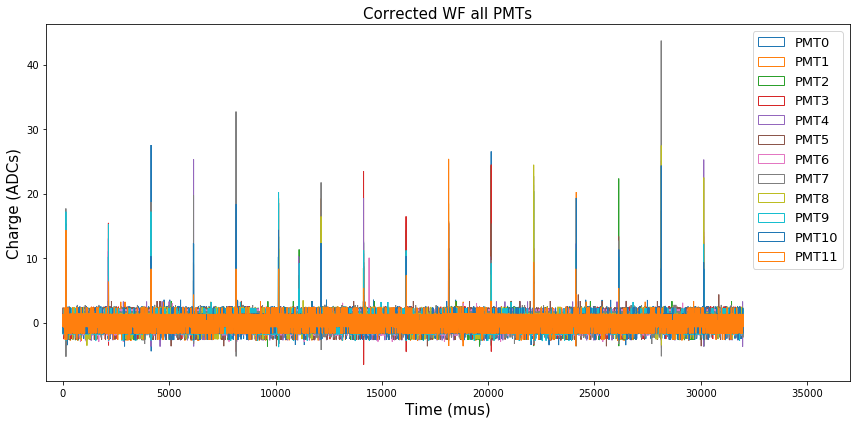

In [9]:
fig = plt.figure(figsize=(12, 6))
for pmt_n in range(12):
    plt.hist(time, bins=bins, weights=corr_wfs[100][pmt_n], range=(0, bins), label=f'PMT{pmt_n}', histtype='step')
plt.xlim(-800,37000)

labels("Time (mus)", "Charge (ADCs)", f'Corrected WF all PMTs', 15)
lnd = plt.legend(loc=1, fontsize=13)
plt.tight_layout()

### SiPMs

In [19]:
run_sipm = 8373
wf_path2 = '/Users/carmenromoluque/Calibration/january2021_cal/SiPM/'
sipm_rwf = tb.open_file(wf_path2 + f'run_{run_sipm}_0000_waveforms.h5')
datSiPM  = db.DataSiPM('new', run_no)

bins = int(80/1)#mus  ## Buffer for SiPMs: 80mus, sample: 1
time = np.array(range(0, bins, 1))

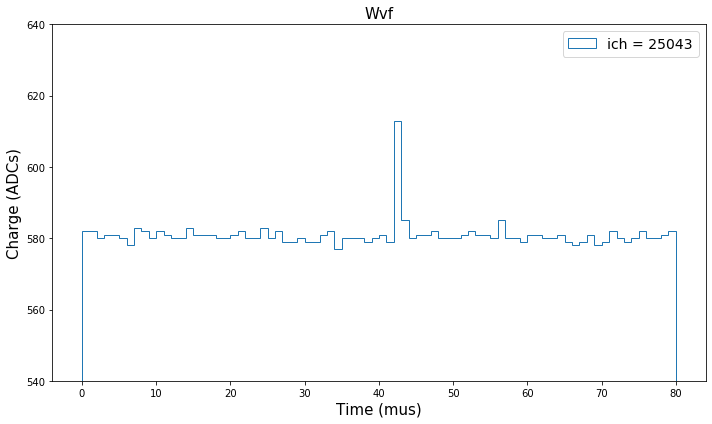

In [26]:
fig     = plt.figure(figsize=(10, 6))
channel = 25043
indx    = datSiPM.index[datSiPM.SensorID==channel]
charges = sipm_rwf.root.RD.sipmrwf[12][indx[0]] # evt 12, SiPM 25043
plt.hist(time, bins=bins, weights=charges, range=(0, bins), label=f'ich = {channel}', histtype='step')
plt.ylim(540,640)

labels("Time (mus)", "Charge (ADCs)", 'Wvf', 15)
lnd = plt.legend(loc=1, fontsize=14)
plt.tight_layout()

In [32]:
sum_all_sipms = np.sum(sipm_rwf.root.RD.sipmrwf, axis=1)

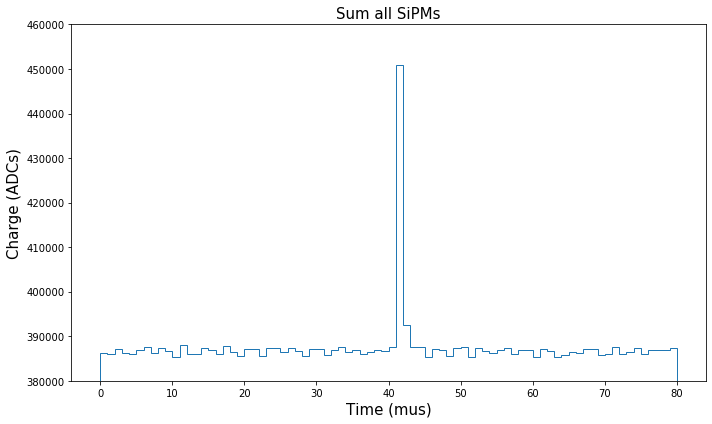

In [36]:
fig = plt.figure(figsize=(10, 6))
plt.hist(time, bins=bins, weights=sum_all_sipms[100], range=(0, bins), label='', histtype='step')
plt.ylim(380000,460000)

labels("Time (mus)", "Charge (ADCs)", 'Sum all SiPMs', 15)
plt.tight_layout()